Original image size: 59885568 bytes
Compressed data size: 479084544 bytes
Decoded image size: 59885568 bytes


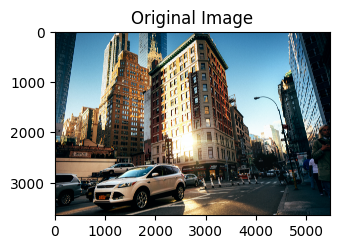

In [13]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

def jpeg_encoder(image, quality=50):
    # Convert image to YCbCr color space
    ycbcr_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

    # Split channels
    y, cb, cr = cv2.split(ycbcr_image)

    # Apply Discrete Cosine Transform (DCT) to each channel
    y_dct = cv2.dct(np.float32(y))
    cb_dct = cv2.dct(np.float32(cb))
    cr_dct = cv2.dct(np.float32(cr))

    # Divide the DCT coefficients into blocks
    block_size = 8
    height, width = y_dct.shape
    y_blocks = [y_dct[j:j+block_size, i:i+block_size] for j in range(0, height, block_size) for i in range(0, width, block_size)]
    cb_blocks = [cb_dct[j:j+block_size, i:i+block_size] for j in range(0, height, block_size) for i in range(0, width, block_size)]
    cr_blocks = [cr_dct[j:j+block_size, i:i+block_size] for j in range(0, height, block_size) for i in range(0, width, block_size)]

    # Quantization
    quantization_matrix = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                               [12, 12, 14, 19, 26, 58, 60, 55],
                               [14, 13, 16, 24, 40, 57, 69, 56],
                               [14, 17, 22, 29, 51, 87, 80, 62],
                               [18, 22, 37, 56, 68, 109, 103, 77],
                               [24, 35, 55, 64, 81, 104, 113, 92],
                               [49, 64, 78, 87, 103, 121, 120, 101],
                               [72, 92, 95, 98, 112, 100, 103, 99]])
    quantization_matrix = np.tile(quantization_matrix, (y_blocks[0].shape[0] // quantization_matrix.shape[0], y_blocks[0].shape[1] // quantization_matrix.shape[1]))
    y_blocks = [block.reshape(quantization_matrix.shape) for block in y_blocks]
    cb_blocks = [block.reshape(quantization_matrix.shape) for block in cb_blocks]
    cr_blocks = [block.reshape(quantization_matrix.shape) for block in cr_blocks]

    # Zigzag reordering
    y_zigzag = np.concatenate([zigzag_reorder(block) for block in y_blocks])
    cb_zigzag = np.concatenate([zigzag_reorder(block) for block in cb_blocks])
    cr_zigzag = np.concatenate([zigzag_reorder(block) for block in cr_blocks])

    # Return the compressed data
    return y_zigzag, cb_zigzag, cr_zigzag, quantization_matrix

# Rest of the code...

def combine_blocks(blocks, height, width):
    image = np.zeros((height, width))
    block_idx = 0
    for i in range(0, height, 8):
        for j in range(0, width, 8):
            if block_idx < len(blocks):
                block = blocks[block_idx]
                if block.shape == (8, 8):
                    image[i:i+8, j:j+8] = block
                else:
                    resized_block = cv2.resize(block, (8, 8), interpolation=cv2.INTER_LINEAR)
                    image[i:i+8, j:j+8] = resized_block
                block_idx += 1
    return image

def jpeg_decoder(y_quantized, cb_quantized, cr_quantized, quantization_matrix, original_image_shape):
    # Determine the dimensions of the image
    height, width, _ = original_image_shape

    # Zigzag reordering (assuming the input is already zigzag reordered)
    y_blocks = [y_quantized[i:i+64].reshape(8, 8) for i in range(0, len(y_quantized), 64)]
    cb_blocks = [cb_quantized[i:i+64].reshape(8, 8) for i in range(0, len(cb_quantized), 64)]
    cr_blocks = [cr_quantized[i:i+64].reshape(8, 8) for i in range(0, len(cr_quantized), 64)]

    # Dequantization
    y_dequantized_blocks = [block * quantization_matrix for block in y_blocks]
    cb_dequantized_blocks = [block * quantization_matrix for block in cb_blocks]
    cr_dequantized_blocks = [block * quantization_matrix for block in cr_blocks]

    # Inverse DCT
    y_idct_blocks = [cv2.idct(np.float32(block)) for block in y_dequantized_blocks]
    cb_idct_blocks = [cv2.idct(np.float32(block)) for block in cb_dequantized_blocks]
    cr_idct_blocks = [cv2.idct(np.float32(block)) for block in cr_dequantized_blocks]

    # Combine blocks into a single image
    y_image = combine_blocks(y_idct_blocks, height, width)
    cb_image = combine_blocks(cb_idct_blocks, height, width)
    cr_image = combine_blocks(cr_idct_blocks, height, width)

    # Merge channels
    ycbcr_image = cv2.merge([y_image, cb_image, cr_image])

    # Convert YCrCb to RGB
    ycbcr_image = np.clip(ycbcr_image, 0, 255).astype(np.uint8)
    rgb_image = cv2.cvtColor(ycbcr_image, cv2.COLOR_YCrCb2RGB)

    # Return the reconstructed image
    return rgb_image

def get_quantization_matrix(quality):
    # Quality range: 1 (poor) to 100 (best)
    if quality < 1:
        quality = 1
    if quality > 100:
        quality = 100

    # Default JPEG quantization matrix
    quant_matrix = np.array([
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99]
    ])

    if quality < 50:
        quality = 5000 / quality
    else:
        quality = 200 - 2 * quality

    quant_matrix = np.round((quant_matrix * quality + 50) / 100)

    return quant_matrix

def zigzag_reorder(matrix):
    rows, cols = matrix.shape
    reordered = np.zeros((rows * cols,))

    i = 0
    for sum_val in range(rows + cols - 1):
        if sum_val % 2 == 0:
            for j in range(min(sum_val, rows - 1), max(-1, sum_val - cols), -1):
                reordered[i] = matrix[j, sum_val - j]
                i += 1
        else:
            for j in range(max(0, sum_val - cols + 1), min(sum_val + 1, rows)):
                reordered[i] = matrix[j, sum_val - j]
                i += 1

    return reordered

def inverse_zigzag_reorder(array):
    size = int(np.sqrt(len(array)))
    matrix = np.zeros((size, size))

    i = 0
    for sum_val in range(size + size - 1):
        if sum_val % 2 == 0:
            for j in range(min(sum_val, size - 1), max(-1, sum_val - size), -1):
                matrix[j, sum_val - j] = array[i]
                i += 1
        else:
            for j in range(max(0, sum_val - size + 1), min(sum_val + 1, size)):
                matrix[j, sum_val - j] = array[i]
                i += 1

    return matrix


# Example usage

# Load the original image
original_image = cv2.imread('/content/img1.jpg')

# Encode the image with quality=50
y_zigzag, cb_zigzag, cr_zigzag, quantization_matrix = jpeg_encoder(original_image, quality=50)

# Calculate the size of the compressed data
compressed_size = y_zigzag.nbytes + cb_zigzag.nbytes + cr_zigzag.nbytes

# Get the shape of the original image
original_image_shape = original_image.shape

# Decode the JPEG compressed image
decoded_image = jpeg_decoder(y_zigzag, cb_zigzag, cr_zigzag, quantization_matrix, original_image_shape)

# Calculate the size of the decoded image
decoded_size = decoded_image.size

# Display the sizes before and after compression
print(f"Original image size: {original_image.size} bytes")
print(f"Compressed data size: {compressed_size} bytes")
print(f"Decoded image size: {decoded_size} bytes")

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

# # Display the decoded image
# plt.subplot(1, 2, 2)
# plt.imshow(decoded_image)
# plt.title('Decoded Image')

# Adjust the spacing and display the plot
plt.tight_layout()
plt.show()